[View in Colaboratory](https://colab.research.google.com/github/ArchanaPrabhu/House-Prices/blob/master/HousePrices.ipynb)

In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

Using TensorFlow backend.


In [4]:


def get_data():
    #get train data
    train_data_path ='train.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='test.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.SalePrice
  train.drop(['SalePrice'],axis = 1 , inplace = True)

  combined = train.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['index', 'Id'], inplace=True, axis=1)
  return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

combined.describe()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [0]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [0]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [7]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


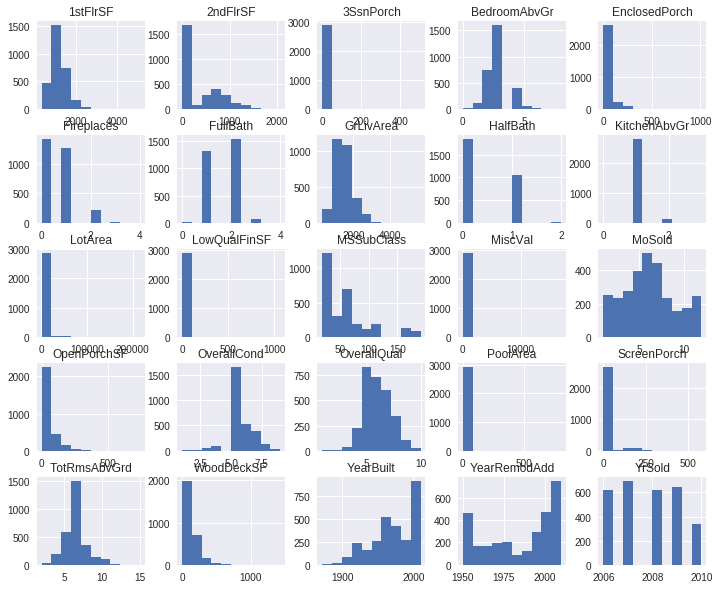

In [8]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

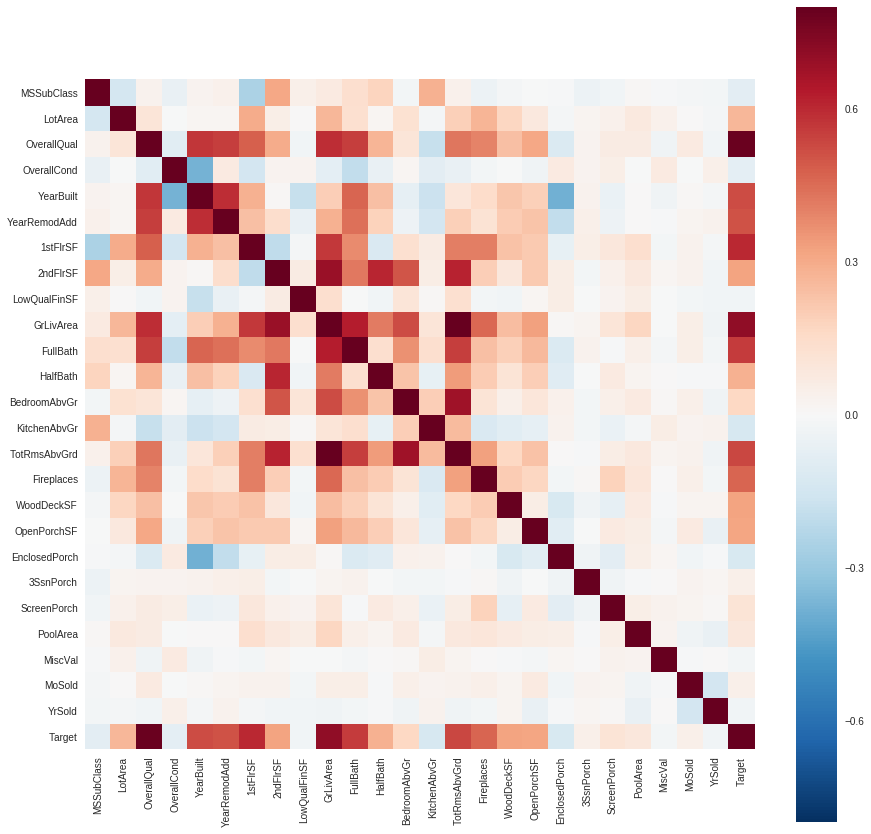

In [9]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [0]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

In [13]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


In [0]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 

In [0]:
train, test = split_combined()

In [0]:
NN_model = Sequential()

In [0]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

In [0]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

In [0]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [29]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               19200     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 184,065
Trainable params: 184,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [51]:
NN_model.fit(train, target, epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 1168 samples, validate on 292 samples
Epoch 1/1000
1168/1168 [==============================] - 0s 343us/step - loss: 27799.1450 - mean_absolute_error: 27799.1450 - val_loss: 30732.7524 - val_mean_absolute_error: 30732.7524

Epoch 00001: val_loss did not improve from 19410.45425
Epoch 2/1000
1168/1168 [==============================] - 0s 137us/step - loss: 26769.6173 - mean_absolute_error: 26769.6173 - val_loss: 30439.3871 - val_mean_absolute_error: 30439.3871

Epoch 00002: val_loss did not improve from 19410.45425
Epoch 3/1000
1168/1168 [==============================] - 0s 138us/step - loss: 27001.4254 - mean_absolute_error: 27001.4254 - val_loss: 30646.5768 - val_mean_absolute_error: 30646.5768

Epoch 00003: val_loss did not improve from 19410.45425
Epoch 4/1000
1168/1168 [==============================] - 0s 133us/step - loss: 26070.6573 - mean_absolute_error: 26070.6573 - val_loss: 29434.3946 - val_mean_absolute_error: 29434.3946

Epoch 00004: val_loss did not improve fr

In [55]:
!ls -l *[Weights-1000].hdf5

-rw-r--r-- 1 root root 2247824 Oct  2 17:25 Weights-002--50878.17530.hdf5
-rw-r--r-- 1 root root 2247824 Oct  2 17:25 Weights-003--44693.79420.hdf5
-rw-r--r-- 1 root root 2247824 Oct  2 17:25 Weights-058--31238.31780.hdf5
-rw-r--r-- 1 root root 2247824 Oct  2 17:25 Weights-063--30815.11350.hdf5
-rw-r--r-- 1 root root 2247824 Oct  2 17:26 Weights-103--24748.37270.hdf5
-rw-r--r-- 1 root root 2247824 Oct  2 17:26 Weights-252--20949.81480.hdf5
-rw-r--r-- 1 root root 2247888 Oct  2 18:05 Weights-816--19112.52590.hdf5


In [0]:
wights_file = 'Weights-072--30229.75005.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [0]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

In [0]:
predictions = NN_model.predict(test)

In [38]:
make_submission(predictions[:,0],'submission(NN).csv')


A submission file has been made


In [50]:
!ls
from google.colab import files
files.download('Submission(XGB).csv.csv')

data_description.txt	       Weights-072--30229.75005.hdf5
sample_data		       Weights-077--29622.59311.hdf5
sample_submission.csv	       Weights-079--29471.11082.hdf5
sample_submission.csv.gz       Weights-081--28910.86414.hdf5
submission(NN).csv.csv	       Weights-084--28741.39822.hdf5
Submission(RF).csv.csv	       Weights-089--28591.85258.hdf5
Submission(XGB).csv.csv        Weights-090--27029.35905.hdf5
test.csv		       Weights-093--26310.85616.hdf5
test.csv.gz		       Weights-099--25738.12265.hdf5
train.csv		       Weights-101--25636.71201.hdf5
train.csv.gz		       Weights-103--24748.37270.hdf5
Weights-001--56113.96206.hdf5  Weights-117--23976.29773.hdf5
Weights-002--50878.17530.hdf5  Weights-120--23711.33406.hdf5
Weights-003--44693.79420.hdf5  Weights-124--23448.75685.hdf5
Weights-004--41445.59402.hdf5  Weights-145--22998.92418.hdf5
Weights-005--39538.41299.hdf5  Weights-146--22897.96929.hdf5
Weights-008--37296.09466.hdf5  Weights-148--22752.30924.hdf5
Weights-009--35828.66074.hdf5

In [0]:
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.25, random_state = 14)

In [42]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  18797.118630136985


In [44]:
predicted_prices = model.predict(test)
make_submission(predicted_prices,'Submission(RF).csv')

A submission file has been made


In [47]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [48]:
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  17869.75410958904


In [49]:
XGBpredictions = XGBModel.predict(test)
make_submission(XGBpredictions,'Submission(XGB).csv')

A submission file has been made
